
## Power Limit Embedded Test Script
Use the python bindings to validate embedded code

Copyright 2019 - Charles Vorbach

Released under [GNU General Public License v3.0](https://www.gnu.org/licenses/gpl-3.0.en.html)

In [155]:
import numpy as np
import matplotlib.pyplot as plt
    
import math
    
# %matplotlib notebook
plt.style.use('ggplot')

In [156]:
import sys
sys.executable

'/home/charlie/.pyenv/versions/3.8.0/envs/james-watt/bin/python3.8'

In [157]:

import ctypes

lib = ctypes.cdll.LoadLibrary("embedded/build/libeffmap.so")

class EfficiencyMap:
    def __init__(self):
        lib.estimate_power_.argtypes = [ctypes.c_float, ctypes.c_float]
        lib.estimate_power_.restype  = ctypes.c_float
    
        lib.estimate_eff_.argtypes = [ctypes.c_float, ctypes.c_float]
        lib.estimate_eff_.restype  = ctypes.c_float
        
        lib.estimate_torque_limit_.argtypes = [ctypes.c_float, ctypes.c_float, ctypes.c_int, ctypes.c_float]
        lib.estimate_torque_limit_.restype  = ctypes.c_float
        
        lib.get_point_.argtypes = [ctypes.c_int, ctypes.c_int]
        lib.get_point_.restype  = ctypes.c_float

    def estimate_power(self, torque, speed):
        return lib.estimate_power_(torque, speed)

    def estimate_eff(self, torque, speed):
        return lib.estimate_eff_(torque, speed)
    
    def estimate_torque_limit(self, POWER_LIMIT, MAX_TORQUE, STEPS, speed):
        return lib.estimate_torque_limit_(POWER_LIMIT, MAX_TORQUE, STEPS, speed)
    
    def get_map_point(self, i, j):
        return lib.get_point_(i, j)

efficiency_map = EfficiencyMap()

(40, 40)
(40, 40)
(40, 40)


<IPython.core.display.Javascript object>


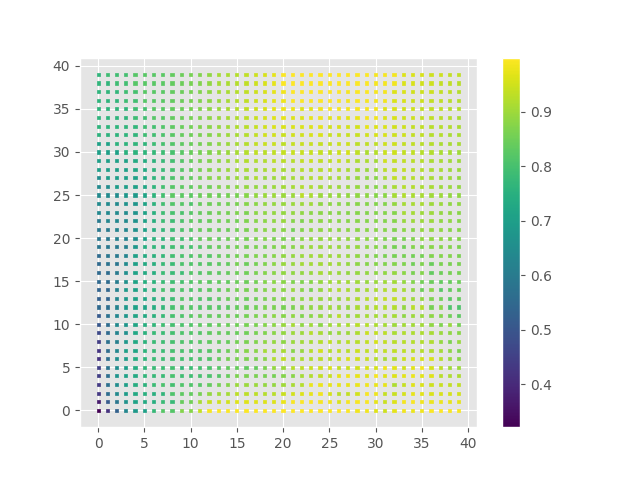

In [158]:
I = 40;
J = 40;

eff_map = np.zeros((I, J))
eff_map[:, :] = np.nan

ii, jj = np.meshgrid(range(I), range(J))

for i in range(I):
    for j in range(J):
        eff_map[i, j]  = efficiency_map.get_map_point(i, j)
        
print(ii.shape)
print(jj.shape)
print(eff_map.shape)
        
fig = plt.figure()
ax = fig.add_subplot(111)
pos = ax.scatter(ii, jj, c=eff_map, s=5, marker='s')
fig.colorbar(pos, ax=ax)
plt.show()

<IPython.core.display.Javascript object>


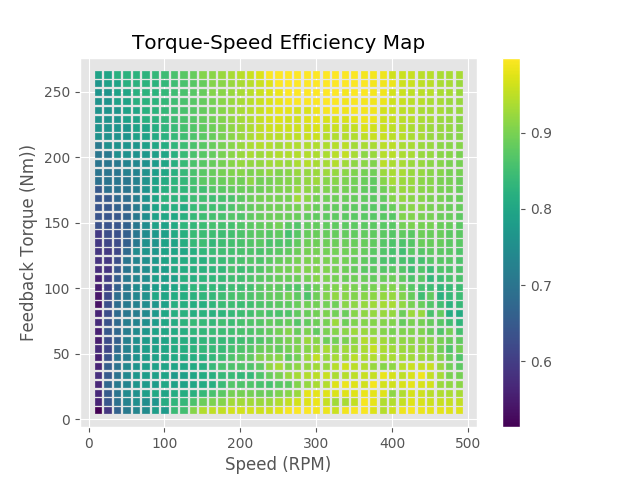

In [159]:
import numpy as np
import matplotlib.pyplot as plt 

BUCKETS = 40
MAX_TORQUE = 270
MAX_SPEED = 500

TORQUE_STEP = MAX_TORQUE / (BUCKETS)
SPEED_STEP = MAX_SPEED / (BUCKETS)

speeds  = [ SPEED_STEP * i for i in range(1, BUCKETS)]
torques = [TORQUE_STEP * i for i in range(1, BUCKETS)] 

vv, tt = np.meshgrid(speeds, torques)

eff_map = np.zeros((len(speeds), len(torques)))
eff_map[:, :] = np.nan

for i,t in enumerate(torques):
    for j,v in enumerate(speeds):
        eff_map[i, j]  = efficiency_map.estimate_eff(t, v)

fig = plt.figure()
ax = fig.add_subplot(111)

pos = ax.scatter(vv, tt, c=eff_map, s=20, marker='s')

fig.colorbar(pos, ax=ax)

plt.title('Torque-Speed Efficiency Map')
plt.xlabel('Speed (RPM)')
plt.ylabel('Feedback Torque (Nm))')

plt.show()


In [162]:
print(eff_map)

[[0.51330501 0.58965999 0.66348404 ... 0.97875398 0.97542399 0.97276998]
 [0.56108701 0.64266604 0.69320703 ... 0.95877892 0.95605296 0.95348793]
 [0.56926602 0.64961296 0.70062697 ... 0.94134998 0.93676299 0.93423903]
 ...
 [0.76368994 0.76716298 0.79224294 ... 0.93646401 0.93418193 0.92474699]
 [0.76600498 0.78992802 0.794559   ... 0.93783402 0.93555093 0.92611599]
 [0.79224294 0.79687399 0.82079709 ... 0.93646401 0.93509501 0.93509501]]


In [271]:
data = np.load('20191020121342.npz')

for k in data:
    pass
    print(k)

UNITS
critical__SetLVChannel
control__RMSModulationIndxFluxWeakeningInfo
critical__CurrentSensor_Power
control__RMSTorqueTimerInfo
control__RMSFaultCodes
control__RMSFluxInfo
control__RMSVoltage
control__RMSMotorPositionInfo
control__RMSTemperature
critical__CellTemperatureRange
critical__BMSHeartbeat
critical__CellVoltageRange
critical__CurrentSensor_Current
sensor__WheelSpeed_BackRight
sensor__AccelPedals
sensor__WheelSpeed_FrontLeft
critical__VCUDashInfo
control__RMSParameterCmd
critical__RMSTemps
critical__BamocarTemps
critical__VCUState
critical__CurrentSensor_Voltage1
critical__CurrentSensor_Voltage2
critical__CurrentSensor_Voltage3
control__RMSCmd
critical__EMeterMeasurement
critical__EMeterStatus
critical__LCdebug
critical__DashRequest
critical__Controls_Settings1
critical__Controls_Settings2
critical__LaunchControlSettings
critical__LVVoltages
critical__LVCurrents
critical__CellTemperatureVariance18


In [272]:

# Sorts series with out-of-order timestamps
def clean_series(times, vals):
    
    # Make everything a float
    times = np.float64(times)
    vals  = np.float64(vals) 
    
    sorted_perm = times.argsort() # Time in increasing order
    
    times = times[sorted_perm]    # Permute to match
    times = times - times[0]      # Start at time zero
    
    vals = vals[sorted_perm]      # Permute to match times
    
    return times, vals            # Note, the passed array's haven't been changed


In [273]:

# Name interesting series

# FEEDBACK TORQUE
feedback_times =       data['control__RMSTorqueTimerInfo']['time']
feedback_vals  = 0.1 * data['control__RMSTorqueTimerInfo']['torque_feedback']  # converts dNm -> Nm
feedback_times, feedback_vals = clean_series(feedback_times, feedback_vals)

plt.plot(feedback_times, feedback_vals, label='Torque Feedback (Nm)')

# COMMANDED TORQUE
cmd_times =       data['control__RMSCmd']['time']
cmd_vals  = 0.1 * data['control__RMSCmd']['torque']                            # converts dNm -> Nm
cmd_times, cmd_vals = clean_series(cmd_times, cmd_vals)

plt.plot(cmd_times, cmd_vals, label='Torque Cmd (Nm)')

# POWER 
pwr_times = data['critical__CurrentSensor_Power']['time']
pwr_vals  = data['critical__CurrentSensor_Power']['result']                    # watts
pwr_times, pwr_vals = clean_series(pwr_times, pwr_vals)

plt.plot(pwr_times, pwr_vals, label='Power (Watts)')

# VOLTAGE
volt_times =         data['critical__CurrentSensor_Voltage1']['time']
volt_vals  = 0.001 * data['critical__CurrentSensor_Voltage1']['result']       # converts mV -> V 
volt_times, volt_vals = clean_series(volt_times, volt_vals)

plt.plot(volt_times, volt_vals, label='Voltage (V)')

# CURRENT
curr_times =         data['critical__CurrentSensor_Current']['time']          
curr_vals  = 0.001 * data['critical__CurrentSensor_Current']['result']        # converts mA -> A
curr_times, curr_vals = clean_series(curr_times, curr_vals)

plt.plot(curr_times, curr_vals, label='Current (A)')

# RESOLVER
resolver_times = data['control__RMSMotorPositionInfo']['time']
resolver_vals =  data['control__RMSMotorPositionInfo']['motor_speed'] * math.pi / 30  # converts RPM -> rad/s
resolver_times, resolver_vals = clean_series(resolver_times, resolver_vals)

plt.plot(resolver_times, resolver_vals, label='Speed (RPM)')

plt.legend()
plt.show()


In [278]:

# Interpolate to get a single time vector

time = pwr_times

feedback = np.interp(time, feedback_times, feedback_vals)
cmd      = np.interp(time, cmd_times, cmd_vals)
pwr      = np.interp(time, pwr_times, pwr_vals)
volt     = np.interp(time, volt_times, volt_vals)
curr     = np.interp(time, curr_times, curr_vals)
resolver = np.interp(time, resolver_times, resolver_vals)

# Plot if you like

# plt.plot(time, interp_feedback, '.', label='Feedback')
# plt.plot(time, interp_cmd,      '.', label='Command')
# plt.plot(time, interp_pwr,      '.', label='Power')
# plt.plot(time, interp_volt,     '.', label='Voltage')
# plt.plot(time, interp_curr,     '.', label='Current')
# plt.plot(time, interp_resolver, '.', label='Resolver')
# plt.legend()


In [279]:

# The current sensor does 0th order interpolation between 33 hertz updates
# The voltage and current have been linearly interpolated and so are less laggy

computed_pwr = interp_volt * interp_curr
power = computed_pwr                        # Use this power

# Plot if you like

# plt.plot(t, computed_pwr, '.', label='Voltage*Current (After Interpolation)')
# plt.plot(t, power, '.',   label='Power Message')
# plt.legend()


In [276]:

# Optionally Load combined data from file

combined_data = np.load("20191020121342.npz")

# Name and clean combined data (runs probably don't have times in order)
# This produces a "merged" run

cmb_resolver = combined_data[:, 0]
cmb_feedback = combined_data[:, 1]
cmb_eff      = combined_data[:, 2]
cmb_power    = combined_data[:, 3]
cmb_predict  = combined_data[:, 4]
cmb_time     = combined_data[:, 5]

raw_time     = np.copy(cmb_time) 

cmb_time, cmb_resolver = clean_series(cmb_time,          cmb_resolver)
_, cmb_feedback        = clean_series(np.copy(raw_time), cmb_feedback)
_, cmb_eff             = clean_series(np.copy(raw_time), cmb_eff)
_, cmb_power           = clean_series(np.copy(raw_time), cmb_power)
_, cmb_predict         = clean_series(np.copy(raw_time), cmb_predict)




TypeError: not all arguments converted during string formatting

In [280]:

# Trim off data contaminated by overspeed fault

OVERSPEED = 5000  # Going faster than this triggers a fault and produces garbage data

good_idx = cmb_resolver < OVERSPEED

time            = cmb_time[good_idx]
feedback        = cmb_feedback[good_idx]
power           = cmb_power[good_idx]
predict         = cmb_predict[good_idx]
resolver        = cmb_resolver[good_idx]
efficiency      = cmb_eff[good_idx]

plt.scatter(resolver, feedback, c=efficiency, s=1)

plt.title('Torque-Speed Efficiencies')
plt.xlabel('Speed (RPM)')
plt.ylabel('Feedback Torque (Nm))')
plt.show()


ValueError: 'c' argument has 615053 elements, which is not acceptable for use with 'x' with size 202198, 'y' with size 202198.

In [281]:

Kp = 0
Ki = 0 #.00001

MAX_EFF = 1.0
MIN_EFF = 0.45
MIN_POWER  = 10000

# Compute power prediction using embedded code
power_predict = np.zeros((feedback.size,))
error = 0
errorSum = 0

for i,(t,v) in enumerate(zip(feedback, resolver)):
    
    estimated_power = efficiency_map.estimate_power(t, v)
    error     = power[i] - estimated_power
    
    power_predict[i] = estimated_power + Kp * error + Ki * errorSum
    
    errorSum += error 
        
# power_predict = np.array([efficiency_map.estimate_power(t,v) for t,v in zip(feedback, resolver)])


<IPython.core.display.Javascript object>


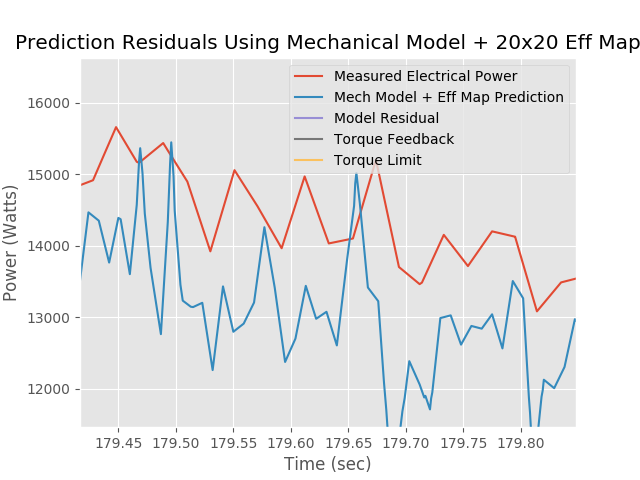

In [284]:

# Plot prediction and residual

residual = power - power_predict
# res2 = power - power_predict

plt.plot(time, power, label='Measured Electrical Power')
plt.plot(time, power_predict, label='Mech Model + Eff Map Prediction')
plt.plot(time, residual, label='Model Residual')

plt.legend()

plt.title('Prediction Residuals Using Mechanical Model + 20x20 Eff Map')
plt.xlabel('Time (sec)')
plt.ylabel('Power (Watts)')
plt.show()

In [292]:

# Compute torque limit

POWER_LIMIT = 40000
MAX_TORQUE  = 300
STEPS       = 100

torque_limit = np.array([efficiency_map.estimate_torque_limit(POWER_LIMIT, MAX_TORQUE, STEPS, s) for s in resolver])


In [293]:

# Estimate power using limited torque and map efficiency

limited_torque = np.minimum(torque_limit, feedback)

limited_power_predict = np.array([efficiency_map.estimate_power(t,v) for t,v in zip(limited_torque, resolver)])

In [294]:

# Plot limited and actual torque

plt.plot(time, feedback,        label="Torque Feedback")
# plt.plot(time, interp_cmd,      label="Torque Command")
plt.plot(time, torque_limit,    label="Torque Limit")

plt.legend()


<IPython.core.display.Javascript object>


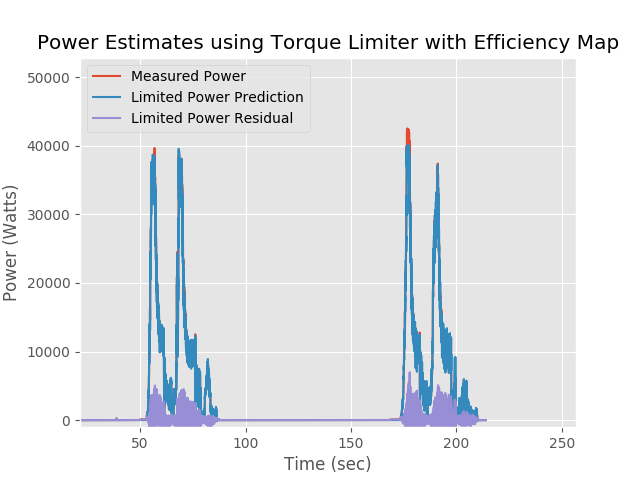

In [295]:

# Plot estimated power

plt.plot(time, power, label="Measured Power")
plt.plot(time, limited_power_predict, label="Limited Power Prediction")
plt.plot(time, power - limited_power_predict, label="Limited Power Residual")

# TODO: Subtract off 2.5 kW bias

plt.legend()

plt.title('Power Estimates using Torque Limiter with Efficiency Map')
plt.xlabel('Time (sec)')
plt.ylabel('Power (Watts)')
plt.show()

In [205]:

# Plot power at prediction

plt.plot(power_predict, power, '.', label='Power')
plt.plot(power_predict, power_predict, label='1-to-1')

plt.legend()
plt.xlabel("Predicted Power (watts)")
plt.ylabel("Measured Power (watts)")
plt.title('Power Prediction Using Mechanical Model + Eff Map')
plt.show()

<IPython.core.display.Javascript object>


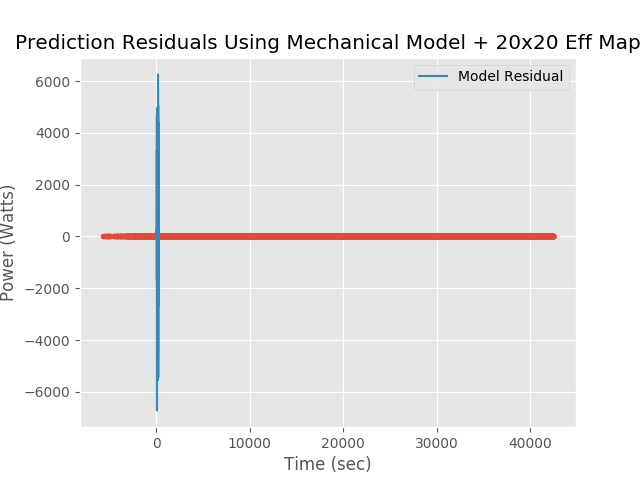

In [258]:

# Plot power at prediction
residuals = power - power_predict
plt.plot(power, residuals, '.')
# plt.plot(power, res2, "b.")

plt.xlabel("Power (watts)")
plt.ylabel("Model Residual Power (watts)")
plt.title('Power Prediction Using Mechanical Model + Eff Map')
plt.show()

In [207]:
import statistics 
statistics.stdev(residuals)

522.1017270338638

<IPython.core.display.Javascript object>


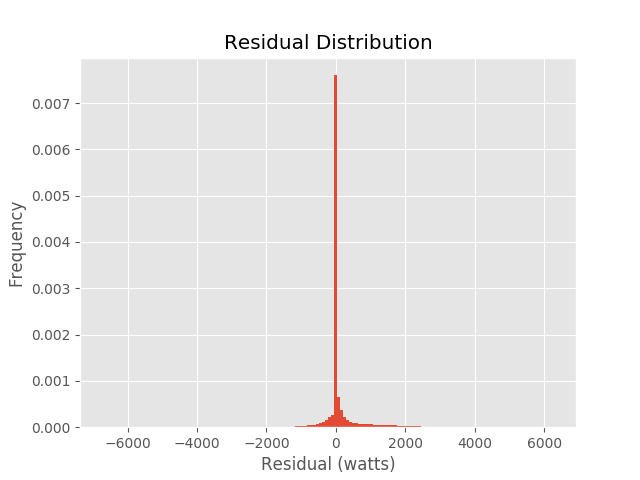

Text(0.5, 1.0, 'Residual Distribution')

In [119]:
import matplotlib.pyplot as plt

plt.hist(residuals, bins=150, histtype='bar', density=True, stacked=True)
plt.xlabel('Residual (watts)')
plt.ylabel('Frequency')
plt.title("Residual Distribution")
plt.show()

<IPython.core.display.Javascript object>


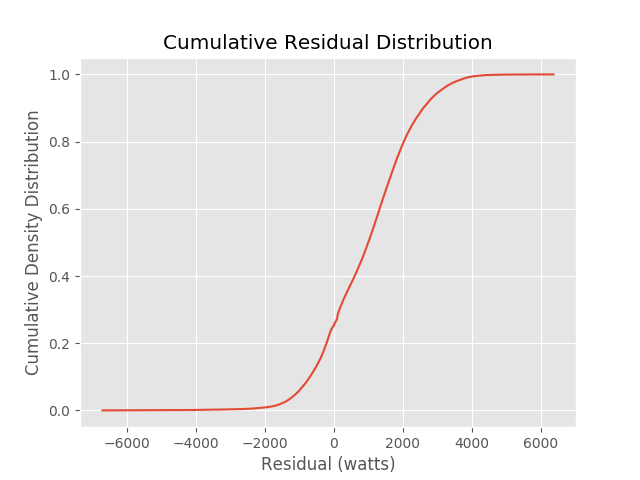

In [209]:
cumulative_distribution = np.abs(np.sort(residuals)).cumsum() / np.abs(np.sort(residuals)).sum()
plt.plot(np.sort(residuals), cumulative_distribution)

plt.xlabel('Residual (watts)')
plt.ylabel('Cumulative Density Distribution')
plt.title("Cumulative Residual Distribution")
plt.show()

<IPython.core.display.Javascript object>


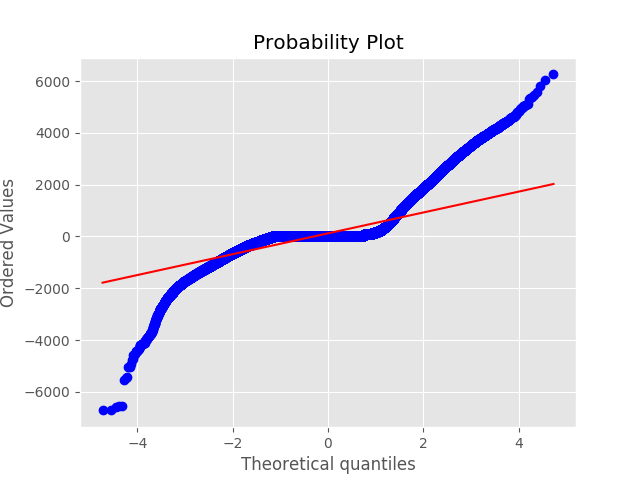

((array([-4.72921089, -4.54586268, -4.44662922, ...,  4.44662922,
          4.54586268,  4.72921089]),
  array([-6719.73300301, -6705.40659626, -6575.17665583, ...,
          5797.96520642,  6029.75371996,  6261.55064895])),
 (402.9854342686664, 120.88354442478561, 0.760509240621875))

In [121]:
import scipy.stats as stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.show()

<IPython.core.display.Javascript object>


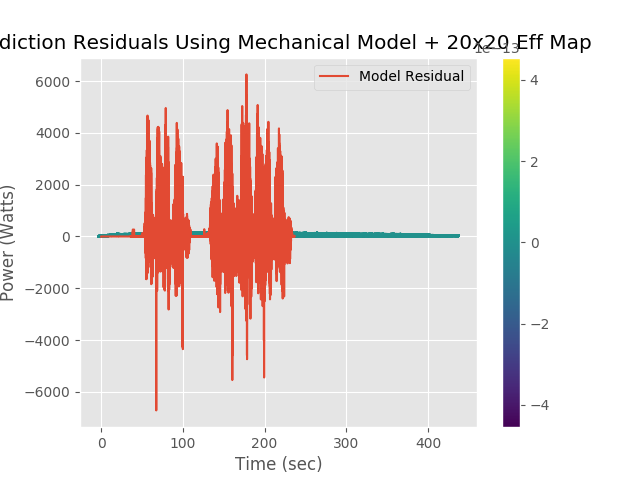

In [263]:
fig = plt.figure()
ax = fig.add_subplot(111)

pos = ax.scatter(resolver, feedback, c=residuals, s=1)
fig.colorbar(pos, ax=ax)

plt.title('Torques-Speed Model Residuals')
plt.xlabel('Speed (RPM)')
plt.ylabel('Feedback Torque (Nm))')
plt.show()

In [123]:

# Load combined data from file

combined_data = np.load("example-combined-data.npy")


In [124]:

# Name and clean combined data (runs probably don't have times in order)
# This produces a "merged" run

cmb_resolver = combined_data[:, 0]
cmb_feedback = combined_data[:, 1]
cmb_eff      = combined_data[:, 2]
cmb_power    = combined_data[:, 3]
cmb_predict  = combined_data[:, 4]
cmb_time     = combined_data[:, 5]

raw_time     = np.copy(cmb_time) 

cmb_time, cmb_resolver = clean_series(cmb_time,          cmb_resolver)
_, cmb_feedback        = clean_series(np.copy(raw_time), cmb_feedback)
_, cmb_eff             = clean_series(np.copy(raw_time), cmb_eff)
_, cmb_power           = clean_series(np.copy(raw_time), cmb_power)
_, cmb_predict         = clean_series(np.copy(raw_time), cmb_predict)


<IPython.core.display.Javascript object>


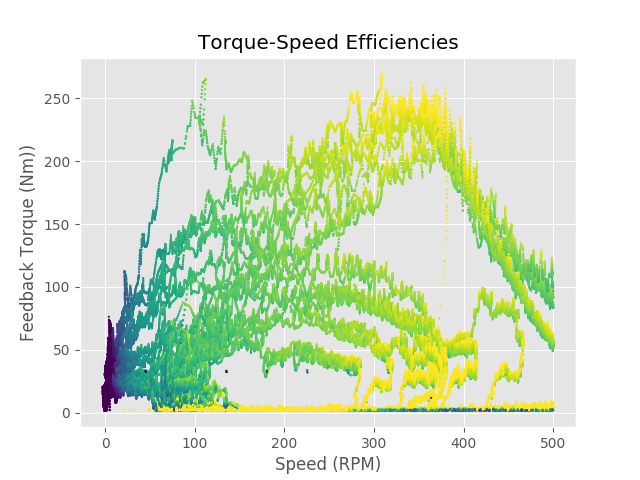

Text(0, 0.5, 'Feedback Torque (Nm))')

In [125]:

# Trim off data contaminated by overspeed fault

OVERSPEED = 500  # Going faster than this triggers a fault and produces garbage data

good_idx = cmb_resolver < OVERSPEED

cmb_time            = cmb_time[good_idx]
cmb_feedback        = cmb_feedback[good_idx]
cmb_power           = cmb_power[good_idx]
cmb_predict         = cmb_predict[good_idx]
cmb_resolver        = cmb_resolver[good_idx]
cmb_eff             = cmb_eff[good_idx]

plt.scatter(cmb_resolver, cmb_feedback, c=cmb_eff, s=1)

plt.title('Torque-Speed Efficiencies')
plt.xlabel('Speed (RPM)')
plt.ylabel('Feedback Torque (Nm))')

<IPython.core.display.Javascript object>


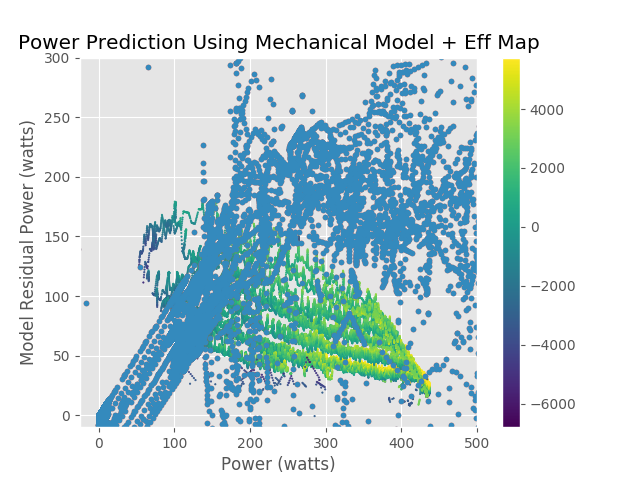

(-25, 500)

In [233]:
partial_residuals = residuals[np.abs(residuals) > 3000]
partial_feedback  = feedback[np.abs(residuals) > 3000] 
partial_resolver  = resolver[np.abs(residuals) > 3000] 

fig = plt.figure()
ax = fig.add_subplot(111)

plt.scatter(cmb_resolver, cmb_feedback, c=cmb_eff, s=1)
pos = ax.scatter(partial_resolver, partial_feedback, c=partial_residuals, s=1)
fig.colorbar(pos, ax=ax)

plt.title('Torques-Speed Model Residuals')
plt.xlabel('Speed (RPM)')
plt.ylabel('Feedback Torque (Nm))')

plt.ylim((-10, 300))
plt.xlim((-25, 500))


<IPython.core.display.Javascript object>


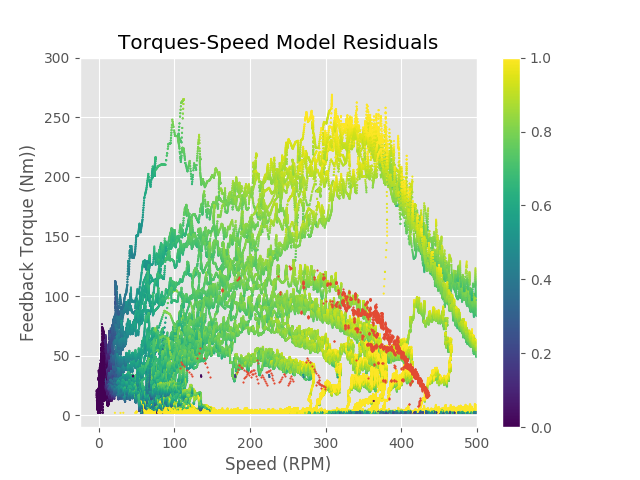

(-25, 500)

In [132]:
partial_residuals = residuals[np.abs(residuals) > 3000]
partial_feedback  = feedback[np.abs(residuals) > 3000] 
partial_resolver  = resolver[np.abs(residuals) > 3000] 

fig = plt.figure()
ax = fig.add_subplot(111)

plt.scatter(cmb_resolver, cmb_feedback, c=cmb_eff, s=1)
pos = ax.scatter(partial_resolver, partial_feedback, s=1)
fig.colorbar(pos, ax=ax)

plt.title('Torques-Speed Model Residuals')
plt.xlabel('Speed (RPM)')
plt.ylabel('Feedback Torque (Nm))')

plt.ylim((-10, 300))
plt.xlim((-25, 500))

<IPython.core.display.Javascript object>


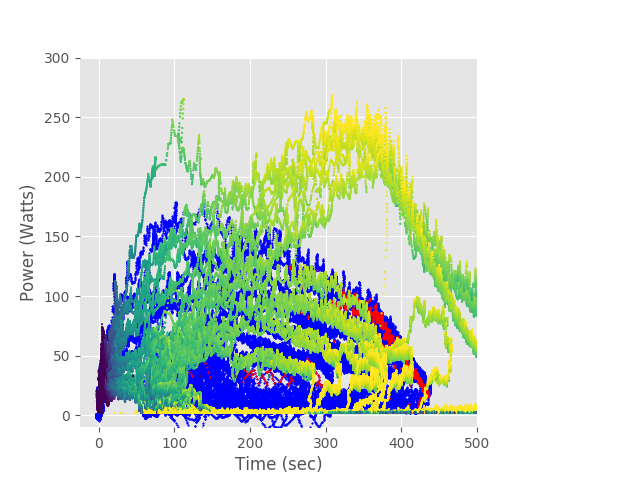

(-25, 500)

In [140]:
partial_residuals = residuals[np.abs(residuals) > 3000]
partial_feedback  = feedback[np.abs(residuals) > 3000] 
partial_resolver  = resolver[np.abs(residuals) > 3000] 

fig = plt.figure()
ax = fig.add_subplot(111)

pos = ax.scatter(resolver, feedback, c="b", s=1)
plt.scatter(partial_resolver, partial_feedback, c="r", s=1)
plt.scatter(cmb_resolver, cmb_feedback, c=cmb_eff, s=1)
fig.colorbar(pos, ax=ax)

plt.title('Torques-Speed Model Residuals')
plt.xlabel('Speed (RPM)')
plt.ylabel('Feedback Torque (Nm))')

plt.ylim((-10, 300))
plt.xlim((-25, 500))

In [ ]:
partial_residuals = residuals[np.where(((resolver < 300) | (feedback < 50)) & (power > 10000))]
partial_feedback  = feedback[np.where(((resolver < 300) | (feedback < 50)) & (power > 10000))] 
partial_resolver  = feedback[np.where(((resolver < 300) | (feedback < 50)) & (power > 10000))] 

partial_cumulative_distribution = np.abs(np.sort(partial_residuals)).cumsum() / np.abs(np.sort(partial_residuals)).sum()
plt.plot(np.sort(residuals), cumulative_distribution)
plt.plot(np.sort(partial_residuals), partial_cumulative_distribution)

plt.xlabel('Residual (watts)')
plt.ylabel('Cumulative Density Distribution')
plt.title("Cumulative Residual Distribution")

plt.legend("")


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

pos = ax.scatter(resolver, feedback, c=partial_residuals, s=1)
fig.colorbar(pos, ax=ax)

plt.title('Torques-Speed Model Residuals')
plt.xlabel('Speed (RPM)')
plt.ylabel('Feedback Torque (Nm))')